Spiele werden simuliert: 100%|██████████| 100000/100000 [00:03<00:00, 26743.92it/s]


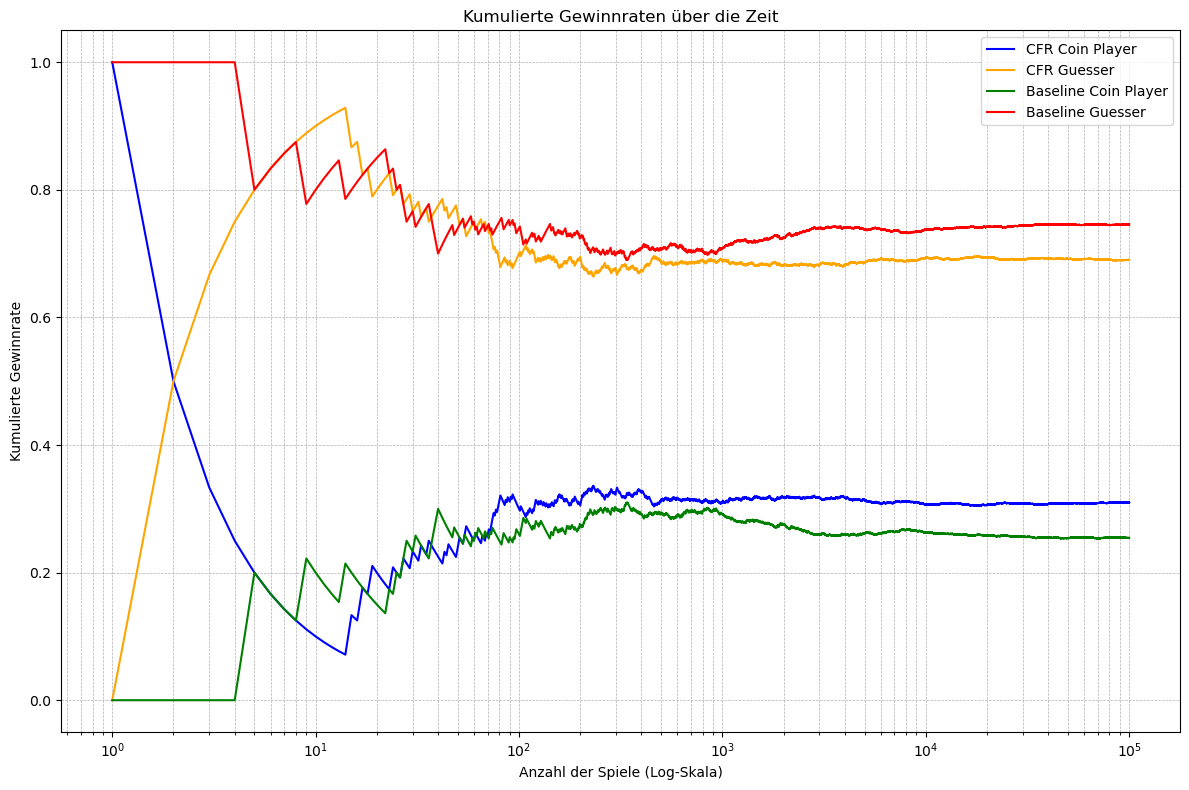

<Figure size 640x480 with 0 Axes>

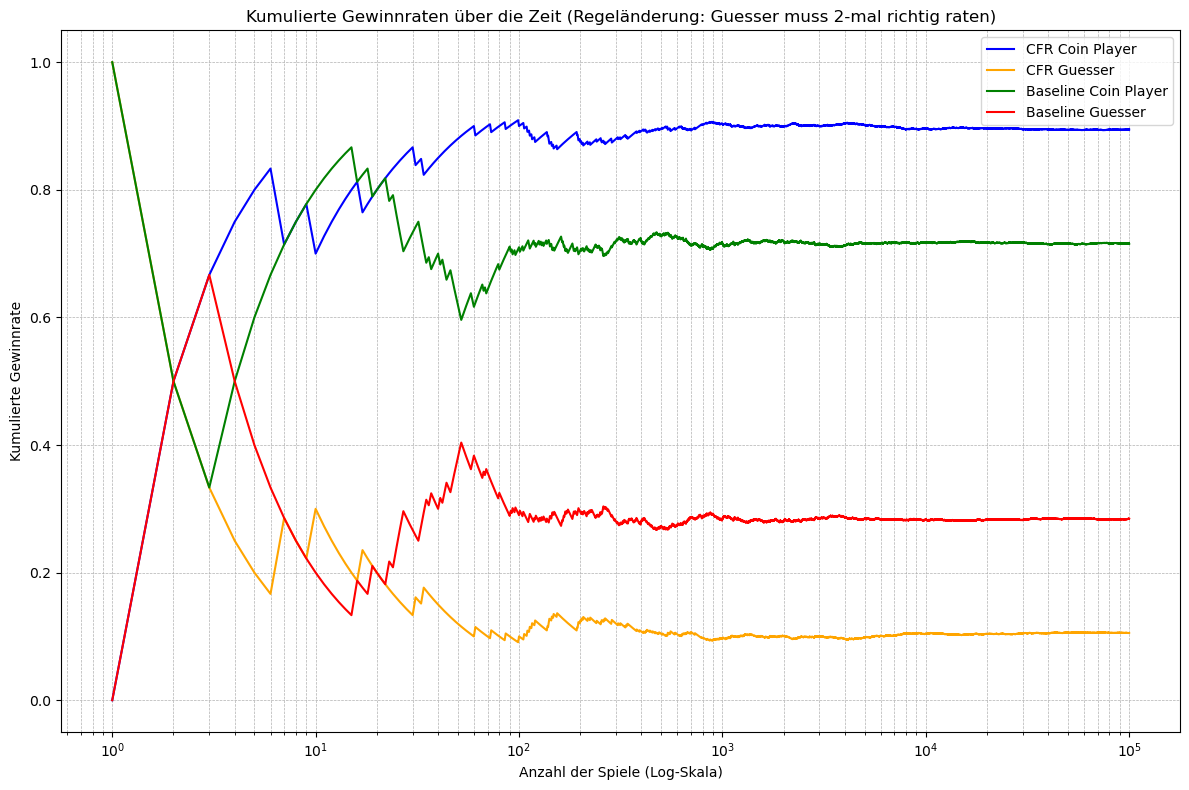


Endergebnisse nach 100000 Spielen mit der 'original' Regel:
CFR Strategie:
  Coin Player Gewinnrate: 30.99%
  Guesser Gewinnrate: 69.01%
Baseline Strategie:
  Coin Player Gewinnrate: 25.44%
  Guesser Gewinnrate: 74.56%

Endergebnisse nach 100000 Spielen mit der 'modified' Regel:
CFR Strategie:
  Coin Player Gewinnrate: 89.46%
  Guesser Gewinnrate: 10.54%
Baseline Strategie:
  Coin Player Gewinnrate: 71.57%
  Guesser Gewinnrate: 28.43%

Anzahl der fehlenden Zustände:
  Coin Player fehlende Zustände: 67829
  Guesser fehlende Zustände: 67829


<Figure size 640x480 with 0 Axes>

In [75]:
import json
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

# Definieren Sie gültige Strategien global
valid_strategies = [
    [0, 1, 2], [0, 1, 3], [0, 1, 4], [0, 1, 5],
    [0, 2, 3], [0, 2, 4], [0, 2, 5], [0, 3, 4],
    [0, 3, 5], [0, 4, 5], [0, 5, 5], [1, 0, 2],
    [1, 0, 3], [1, 0, 4], [1, 0, 5], [1, 2, 0],
    [1, 2, 3], [1, 2, 4], [1, 2, 5], [1, 3, 0],
    [1, 3, 4], [1, 3, 5], [1, 4, 0], [1, 4, 5],
    [1, 5, 0], [1, 5, 5], [2, 0, 3], [2, 0, 4],
    [2, 0, 5], [2, 3, 0], [2, 3, 4], [2, 3, 5],
    [2, 4, 0], [2, 4, 5], [2, 5, 0], [2, 5, 5],
    [3, 0, 4], [3, 0, 5], [3, 4, 0], [3, 4, 5],
    [3, 5, 0], [3, 5, 5], [4, 0, 5], [4, 5, 0],
    [4, 5, 5], [5, 0, 5], [5, 5, 0], [5, 5, 5]
]

# Laden Sie CFR-Strategien aus einer JSON-Datei
def load_cfr_strategies(filename):
    with open(filename, 'r') as file:
        cfr_data = json.load(file)
    strategies = {}
    for entry in cfr_data:
        key = (entry['player'], tuple(entry['coin_player_choices']), tuple(entry['estimator_guesses']), entry['round'])
        strategies[key] = entry['actions']
    return strategies

# Baseline Coin Player Strategie
def baseline_coin_player():
    rounds = []
    is_zero_used = False
    is_five_used = False
    last_non_zero = None

    # Runde 1
    round1 = random.randint(0, 5)
    rounds.append(round1)
    is_zero_used = (round1 == 0)
    is_five_used = (round1 == 5)

    # Runde 2
    if is_zero_used:
        round2 = random.randint(1, 5)
    elif is_five_used:
        round2 = random.choice([0, 5])
    else:
        while True:
            round2 = random.randint(0, 5)
            if round2 > round1 or round2 == 0:
                break
    rounds.append(round2)
    if round2 != 0:
        last_non_zero = round2
    is_zero_used = is_zero_used or (round2 == 0)
    is_five_used = is_five_used or (round2 == 5)

    # Runde 3
    if is_five_used and is_zero_used:
        round3 = 5
    elif is_five_used and not is_zero_used:
        round3 = random.choice([0, 5])
    elif is_zero_used:
        if last_non_zero is None:
            last_non_zero = round1
        while True:
            round3 = random.randint(1, 5)
            if round3 > last_non_zero:
                break
    else:
        while True:
            round3 = random.randint(0, 5)
            if round3 > round2 or round3 == 0:
                break
    rounds.append(round3)

    return rounds

# Baseline Guesser Strategie
def baseline_guesser(previous_coin_choices, current_round):
    if current_round < 1 or current_round > 3:
        raise ValueError("current_round muss zwischen 1 und 3 liegen.")

    if current_round == 1:
        # Erste Runde: zufällige Schätzung
        return random.randint(0, 5)
    else:
        # Bestimmen Sie das Präfix basierend auf den vorherigen Runden
        prefix = previous_coin_choices[:current_round - 1]
        
        # Filtern Sie gültige Strategien, die zum Präfix passen
        matching_strategies = [
            strategy for strategy in valid_strategies
            if strategy[:current_round - 1] == prefix
        ]
        
        if not matching_strategies:
            return random.randint(0, 5)
        
        # Extrahieren Sie mögliche Schätzungen für die aktuelle Runde aus den passenden Strategien
        possible_guesses = set(
            strategy[current_round - 1] for strategy in matching_strategies
        )
        
        # Wählen Sie zufällig aus den möglichen Schätzungen
        return random.choice(list(possible_guesses))

# Hilfsfunktion für gewichtete Auswahl
def weighted_choice(actions):
    total = sum(actions.values())
    r = random.uniform(0, total)
    upto = 0
    for action, weight in actions.items():
        upto += weight
        if upto >= r:
            # Extrahieren Sie die gewählte Zahl aus dem Aktionsstring
            try:
                choice = int(action.split(': ')[1])
            except (IndexError, ValueError):
                choice = random.randint(0, 5)
            return choice
    return random.randint(0, 5)

# Funktion zur Simulation eines einzelnen Spiels
def simulate_game_cfr(coin_player_strategy, guesser_strategy, cfr_strategies, missing_state_counter, rule='original'):
    """
    Simuliert ein einzelnes Spiel unter Verwendung von CFR-Strategien.

    Args:
        coin_player_strategy (str): Strategie für Coin Player ('cfr' oder 'baseline').
        guesser_strategy (str): Strategie für Guesser ('cfr' oder 'baseline').
        cfr_strategies (dict): Geladene CFR-Strategien.
        missing_state_counter (dict): Wörterbuch zur Zählung fehlender Zustände.
        rule (str): Spielregel ('original' oder 'modified').

    Returns:
        dict: Ergebnis des Spiels mit 'winner' und 'rounds'.
    """
    coin_player_choices = []
    estimator_guesses = []
    correct_guesses = 0  # Zähler für korrekte Schätzungen

    for round_num in range(1, 4):
        # Coin Player
        if coin_player_strategy == 'cfr':
            key_coin = (0, tuple(coin_player_choices), tuple(estimator_guesses), round_num)
            actions_coin = cfr_strategies.get(key_coin, {})
            if actions_coin:
                coin_choice = weighted_choice(actions_coin)
            else:
                missing_state_counter['coin_player_missing'] += 1
                coin_choice = random.randint(0, 5)
        else:
            # Baseline Strategie
            if len(coin_player_choices) < 3:
                coin_player_choices = baseline_coin_player()
            coin_choice = coin_player_choices[round_num - 1]

        # Guesser
        if guesser_strategy == 'cfr':
            key_guesser = (1, tuple(coin_player_choices), tuple(estimator_guesses), round_num)
            actions_guesser = cfr_strategies.get(key_guesser, {})
            if actions_guesser:
                guess = weighted_choice(actions_guesser)
            else:
                missing_state_counter['guesser_missing'] += 1
                guess = random.randint(0, 5)
        else:
            # Baseline Strategie
            guess = baseline_guesser(coin_player_choices, round_num)

        # Entscheidungen gleichzeitig hinzufügen
        coin_player_choices.append(coin_choice)
        estimator_guesses.append(guess)

        # Überprüfen, ob Guesser in dieser Runde richtig geraten hat
        if guess == coin_choice:
            correct_guesses += 1

        # Früher Abbruch für ursprüngliche Regel
        if rule == 'original' and correct_guesses >= 1:
            return {'winner': 'Guesser', 'rounds': round_num}

    # Bestimmen Sie den Gewinner basierend auf der Regel
    if rule == 'original':
        # Nach drei Runden, falls Guesser nicht gewonnen hat
        return {'winner': 'Coin Player', 'rounds': 3}
    elif rule == 'modified':
        # Guesser gewinnt, wenn er mindestens zwei Mal richtig geraten hat
        if correct_guesses >= 2:
            return {'winner': 'Guesser', 'rounds': 3}
        else:
            return {'winner': 'Coin Player', 'rounds': 3}
    else:
        raise ValueError("Unbekannte Regel. Verwenden Sie 'original' oder 'modified'.")

# Funktion zur Durchführung der Simulation und zum Erstellen der Plots
def run_simulation_with_tracking(num_games, cfr_filename):
    cfr_strategies = load_cfr_strategies(cfr_filename)
    results = defaultdict(int)

    # Ergebnisse für beide Regeln
    rules = ['original', 'modified']
    cumulative_results = {
        'original': {
            'cfr_coin_wins': [],
            'cfr_guesser_wins': [],
            'baseline_coin_wins': [],
            'baseline_guesser_wins': [],
            'cumulative_cfr_coin': 0,
            'cumulative_cfr_guesser': 0,
            'cumulative_baseline_coin': 0,
            'cumulative_baseline_guesser': 0
        },
        'modified': {
            'cfr_coin_wins': [],
            'cfr_guesser_wins': [],
            'baseline_coin_wins': [],
            'baseline_guesser_wins': [],
            'cumulative_cfr_coin': 0,
            'cumulative_cfr_guesser': 0,
            'cumulative_baseline_coin': 0,
            'cumulative_baseline_guesser': 0
        }
    }

    # Fehlende Zustände zählen
    missing_state_counter = {
        'coin_player_missing': 0,
        'guesser_missing': 0
    }

    for i in tqdm(range(1, num_games + 1), desc="Spiele werden simuliert"):
        for rule in rules:
            # Simulieren Sie das Spiel mit CFR-Strategie
            cfr_result = simulate_game_cfr('cfr', 'cfr', cfr_strategies, missing_state_counter, rule=rule)
            if cfr_result['winner'] == 'Guesser':
                cumulative_results[rule]['cumulative_cfr_guesser'] += 1
            else:
                cumulative_results[rule]['cumulative_cfr_coin'] += 1

            cumulative_results[rule]['cfr_coin_wins'].append(cumulative_results[rule]['cumulative_cfr_coin'] / i)
            cumulative_results[rule]['cfr_guesser_wins'].append(cumulative_results[rule]['cumulative_cfr_guesser'] / i)

            # Simulieren Sie das Spiel mit Baseline-Strategie
            baseline_result = simulate_game_cfr('baseline', 'baseline', cfr_strategies, missing_state_counter, rule=rule)
            if baseline_result['winner'] == 'Guesser':
                cumulative_results[rule]['cumulative_baseline_guesser'] += 1
            else:
                cumulative_results[rule]['cumulative_baseline_coin'] += 1

            cumulative_results[rule]['baseline_coin_wins'].append(cumulative_results[rule]['cumulative_baseline_coin'] / i)
            cumulative_results[rule]['baseline_guesser_wins'].append(cumulative_results[rule]['cumulative_baseline_guesser'] / i)

    # Plotting für jede Regel
    for rule in rules:
        games = list(range(1, num_games + 1))

        plt.figure(figsize=(12, 8))
        plt.plot(games, cumulative_results[rule]['cfr_coin_wins'], label='CFR Coin Player', color='blue')
        plt.plot(games, cumulative_results[rule]['cfr_guesser_wins'], label='CFR Guesser', color='orange')
        plt.plot(games, cumulative_results[rule]['baseline_coin_wins'], label='Baseline Coin Player', color='green')
        plt.plot(games, cumulative_results[rule]['baseline_guesser_wins'], label='Baseline Guesser', color='red')
        plt.xscale('log')
        plt.xlabel('Anzahl der Spiele (Log-Skala)')
        plt.ylabel('Kumulierte Gewinnrate')
        if rule == 'original':
            plt.title('Kumulierte Gewinnraten über die Zeit')
        elif rule == 'modified':
            plt.title('Kumulierte Gewinnraten über die Zeit (Regeländerung: Guesser muss 2-mal richtig raten)')
        plt.legend()
        plt.grid(True, which="both", ls="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'expected_values_cfr_rulebased_simulation_{rule}.png')

    # Endergebnisse ausdrucken
    for rule in rules:
        print(f"\nEndergebnisse nach {num_games} Spielen mit der '{rule}' Regel:")
        print("CFR Strategie:")
        print(f"  Coin Player Gewinnrate: {cumulative_results[rule]['cumulative_cfr_coin'] / num_games * 100:.2f}%")
        print(f"  Guesser Gewinnrate: {cumulative_results[rule]['cumulative_cfr_guesser'] / num_games * 100:.2f}%")
        print("Baseline Strategie:")
        print(f"  Coin Player Gewinnrate: {cumulative_results[rule]['cumulative_baseline_coin'] / num_games * 100:.2f}%")
        print(f"  Guesser Gewinnrate: {cumulative_results[rule]['cumulative_baseline_guesser'] / num_games * 100:.2f}%")

    # Fehlende Zustände ausdrucken
    print("\nAnzahl der fehlenden Zustände:")
    print(f"  Coin Player fehlende Zustände: {missing_state_counter['coin_player_missing']}")
    print(f"  Guesser fehlende Zustände: {missing_state_counter['guesser_missing']}")

# Simulation mit beiden Regeln ausführen
if __name__ == "__main__":
    num_games = 100000  # Anpassen nach Bedarf
    cfr_filename = '../data/game_tree_results_cfr.json'
    run_simulation_with_tracking(num_games, cfr_filename)

In [ ]:
def validate_baseline_strategy():
    valid_strategies = [
        [0, 1, 2], [0, 1, 3], [0, 1, 4], [0, 1, 5],
        [0, 2, 3], [0, 2, 4], [0, 2, 5], [0, 3, 4],
        [0, 3, 5], [0, 4, 5], [0, 5, 5], [1, 0, 2],
        [1, 0, 3], [1, 0, 4], [1, 0, 5], [1, 2, 0],
        [1, 2, 3], [1, 2, 4], [1, 2, 5], [1, 3, 0],
        [1, 3, 4], [1, 3, 5], [1, 4, 0], [1, 4, 5],
        [1, 5, 0], [1, 5, 5], [2, 0, 3], [2, 0, 4],
        [2, 0, 5], [2, 3, 0], [2, 3, 4], [2, 3, 5],
        [2, 4, 0], [2, 4, 5], [2, 5, 0], [2, 5, 5],
        [3, 0, 4], [3, 0, 5], [3, 4, 0], [3, 4, 5],
        [3, 5, 0], [3, 5, 5], [4, 0, 5], [4, 5, 0],
        [4, 5, 5], [5, 0, 5], [5, 5, 0], [5, 5, 5]
    ]

    # Convert list to set
    valid_strategies_set = set(tuple(strategy) for strategy in valid_strategies)

    # Run multiple simulations of the baseline algorithm
    invalid_strategies = []
    for _ in range(10000):
        strategy = baseline_coin_player()
        if tuple(strategy) not in valid_strategies_set:
            invalid_strategies.append(strategy)

    if not invalid_strategies:
        print("Test Passed: All baseline strategies are valid.")
    else:
        print(f"Test Failed: Found {len(invalid_strategies)} invalid strategies.")
        print("Invalid strategies:", invalid_strategies[:10])

if __name__ == "__main__":
    validate_baseline_strategy()

Test Passed: All baseline strategies are valid.


Simulating CFR vs. Coin Player Strategies: 100%|██████████| 48/48 [00:04<00:00, 10.19it/s]


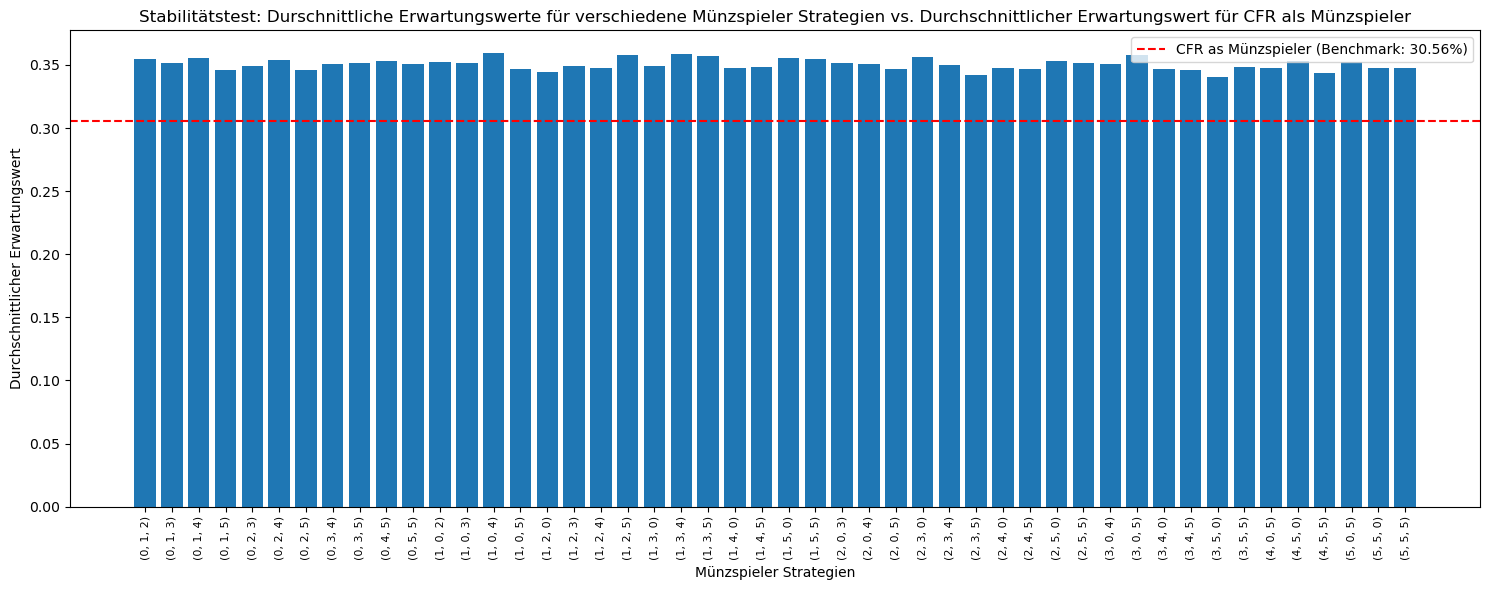

Missing States Count:


In [ ]:
def simulate_cfr_vs_coinplayer_strategies(valid_strategies, cfr_strategies, num_games=10000):
    """
    Simulates games between CFR and each Coin Player strategy, calculates mean expected values, 
    and tracks missing states.
    
    Args:
        valid_strategies (list): List of valid Coin Player strategies (tuples).
        cfr_strategies (dict): Loaded CFR strategy JSON.
        num_games (int): Number of games to simulate for each strategy.
    
    Returns:
        tuple: (mean_values, missing_states_count) where:
            mean_values is a dict of mean expected values for each strategy.
            missing_states_count is the count of missing states.
    """
    mean_values = {}
    missing_states_count = defaultdict(int)

    # Simulate CFR vs. each Coin Player strategy
    for strategy in tqdm(valid_strategies, desc="Simulating CFR vs. Coin Player Strategies"):
        total_value = 0

        for _ in range(num_games):
            result = simulate_game_cfr('cfr', 'baseline', cfr_strategies, missing_states_count)
            if result['winner'] == 'Coin Player':
                total_value += 1

        mean_values[tuple(strategy)] = total_value / num_games

    # Simulate CFR playing as Coin Player against itself
    cfr_vs_cfr_value = 0
    for _ in range(num_games):
        result = simulate_game_cfr('cfr', 'cfr', cfr_strategies, missing_states_count)
        if result['winner'] == 'Coin Player':
            cfr_vs_cfr_value += 1

    cfr_mean_value = cfr_vs_cfr_value / num_games

    return mean_values, cfr_mean_value, missing_states_count


def plot_mean_values(mean_values, cfr_mean_value):
    """
    Plots the mean expected values for all Coin Player strategies against CFR.
    
    Args:
        mean_values (dict): Mean expected values for each Coin Player strategy.
        cfr_mean_value (float): Mean expected value for CFR playing as Coin Player.
    """
    strategies = list(mean_values.keys())
    values = list(mean_values.values())


    plt.figure(figsize=(15, 6))
    plt.bar(range(len(strategies)), values, tick_label=[str(strategy) for strategy in strategies], align='center')
    plt.axhline(y=cfr_mean_value, color='red', linestyle='--', label=f'CFR as Münzspieler (Benchmark: {cfr_mean_value:.2%})')
    plt.xlabel('Münzspieler Strategien')
    plt.ylabel('Durchschnittlicher Erwartungswert')
    plt.title('Stabilitätstest: Durschnittliche Erwartungswerte für verschiedene Münzspieler Strategien vs. Durchschnittlicher Erwartungswert für CFR als Münzspieler')
    plt.xticks(rotation=90, fontsize=8)
    plt.legend()
    plt.tight_layout()
    plt.show()



# Load the CFR strategies
cfr_filename = '../data/game_tree_results_cfr.json'
cfr_strategies = load_cfr_strategies(cfr_filename)

mean_values, cfr_mean_value, missing_states_count = simulate_cfr_vs_coinplayer_strategies(valid_strategies, cfr_strategies, num_games=10000)

plot_mean_values(mean_values, cfr_mean_value)

print("Missing States Count:")
for key, value in missing_states_count.items():
    print(f"{key}: {value}")


In [ ]:
def simulate_cfr_as_coinplayer(valid_strategies, cfr_strategies, num_games=100000):
    """
    Simulates games where the CFR acts as the Coin Player and plays against the baseline model as the Guesser.
    """
    total_value = 0
    missing_states_count = defaultdict(int)

    for _ in tqdm(range(num_games), desc="Simulating CFR as Coin Player"):
        # Simulate the game with CFR as Coin Player and baseline as Guesser
        result = simulate_game_cfr('cfr', 'baseline', cfr_strategies, missing_states_count)
        if result['winner'] == 'Coin Player':
            total_value += 1

    mean_value = total_value / num_games

    return mean_value, missing_states_count


mean_value, missing_states_count = simulate_cfr_as_coinplayer(valid_strategies, cfr_strategies, num_games=100000)

print(f"Mean Expected Value for CFR as Coin Player: {mean_value:.2%}")
print("\nMissing States Count:")
for key, value in missing_states_count.items():
    print(f"{key}: {value}")



Simulating CFR as Coin Player: 100%|██████████| 100000/100000 [00:01<00:00, 99710.12it/s]

Mean Expected Value for CFR as Coin Player: 35.02%

Missing States Count:


In [71]:
def simulate_baseline_coinplayer_vs_cfr_guesser(cfr_strategies, valid_strategies, num_games=100000):
    """
    Simulates games where the 'baseline' model acts as the Coin Player and CFR as the Guesser.
    The Coin Player randomly selects valid moves based on the JSON tree without using probabilities,
    therefore plays like the baseline model.
    """
    total_value = 0
    missing_states_count = defaultdict(int)

    for _ in tqdm(range(num_games), desc="Simulating Baseline Coin Player vs. CFR Guesser"):
        # Simulate a single game
        coin_player_choices = []
        estimator_guesses = []

        for round_num in range(1, 4):
            # Coinplayer (Baseline/Radnom CFR)
            key_coin = (0, tuple(coin_player_choices), tuple(estimator_guesses), round_num)
            actions_coin = cfr_strategies.get(key_coin, {})
            if actions_coin:
                # Choose randomly from available actions
                coin_choice = random.choice(list(actions_coin.keys()))
                try:
                    coin_choice = int(coin_choice.split(': ')[1])
                except (IndexError, ValueError):
                    coin_choice = random.randint(0, 5)
            else:
                coin_choice = random.randint(0, 5)

            # Guesser (CFR)
            key_guesser = (1, tuple(coin_player_choices), tuple(estimator_guesses), round_num)
            actions_guesser = cfr_strategies.get(key_guesser, {})
            if actions_guesser:
                guess = weighted_choice(actions_guesser)
            else:
                missing_states_count['guesser_missing'] += 1
                guess = random.randint(0, 5)

            coin_player_choices.append(coin_choice)
            estimator_guesses.append(guess)

            if guess == coin_choice:
                total_value += 1
                break  # Guesser wins, end the game

    mean_value = total_value / num_games
    return mean_value, missing_states_count


mean_value, missing_states_count = simulate_baseline_coinplayer_vs_cfr_guesser(cfr_strategies, valid_strategies, num_games=100000)

print(f"Mean Expected Value for CFR as Guesser: {mean_value:.2%}")
print("\nMissing States Count:")
for key, value in missing_states_count.items():
    print(f"{key}: {value}")


Simulating Baseline Coin Player vs. CFR Guesser: 100%|██████████| 100000/100000 [00:00<00:00, 197506.72it/s]

Mean Expected Value for CFR as Guesser: 78.10%

Missing States Count:


In [ ]:
def simulate_game_with_logging(coin_player_strategy, guesser_strategy, cfr_strategies):
    """
    Simulates one game where both players make simultaneous moves.
    Logs each round's state, available actions, and probabilities.
    """
    coin_player_choices = []
    estimator_guesses = []

    print("Starting CFR Simulation...\n")
    for round_num in range(1, 4):
        print(f"Round {round_num}:")

        # Coinplayer
        if coin_player_strategy == 'cfr':
            key_coin = (0, tuple(coin_player_choices), tuple(estimator_guesses), round_num)
            actions_coin = cfr_strategies.get(key_coin, {})
            print(f"  Current State for Coin Player: {key_coin}")
            if actions_coin:
                print(f"  Possible Actions for Coin Player (Probabilities): {actions_coin}")
                coin_choice = weighted_choice(actions_coin)
            else:
                print("  No actions found in CFR strategies for Coin Player, defaulting to random choice.")
                coin_choice = random.randint(0, 5)
        else:
            print("  Using baseline strategy for Coin Player.")
            if not coin_player_choices:
                coin_player_choices = baseline_coin_player()
            coin_choice = coin_player_choices[round_num - 1]

        # Guesser
        if guesser_strategy == 'cfr':
            key_guesser = (1, tuple(coin_player_choices), tuple(estimator_guesses), round_num)
            actions_guesser = cfr_strategies.get(key_guesser, {})
            print(f"  Current State for Guesser: {key_guesser}")
            if actions_guesser:
                print(f"  Possible Actions for Guesser (Probabilities): {actions_guesser}")
                guess = weighted_choice(actions_guesser)
            else:
                print("  No actions found in CFR strategies for Guesser, defaulting to random guess.")
                guess = random.randint(0, 5)
        else:
            print("  Using baseline strategy for Guesser.")
            guess = baseline_guesser(coin_player_choices, round_num)

        coin_player_choices.append(coin_choice)
        estimator_guesses.append(guess)

        print(f"  Coin Player chooses: {coin_choice}")
        print(f"  Guesser guesses: {guess}")

        if guess == coin_choice:
            print(f"\nGuesser wins in Round {round_num}!\n")
            return {'winner': 'Guesser', 'rounds': round_num}

    print("\nCoin Player wins after 3 rounds!\n")
    return {'winner': 'Coin Player', 'rounds': 3}



if __name__ == "__main__":
    cfr_filename = '../data/game_tree_results_cfr.json'
    cfr_strategies = load_cfr_strategies(cfr_filename)
    simulate_game_with_logging('cfr', 'cfr', cfr_strategies)


Starting CFR Simulation...

Round 1:
  Current State for Coin Player: (0, (), (), 1)
  Possible Actions for Coin Player (Probabilities): {'Player 0 chose: 0': 0.24533044370235046, 'Player 0 chose: 1': 0.20821028707827893, 'Player 0 chose: 2': 0.2376459548698358, 'Player 0 chose: 3': 0.3076985585317004, 'Player 0 chose: 4': 0.0005573779089172269, 'Player 0 chose: 5': 0.0005573779089172269}
  Current State for Guesser: (1, (), (), 1)
  Possible Actions for Guesser (Probabilities): {'Player 1 chose: 0': 0.25988625751904787, 'Player 1 chose: 1': 0.37487804323307344, 'Player 1 chose: 2': 0.28425161214453815, 'Player 1 chose: 3': 0.0796504574737109, 'Player 1 chose: 4': 0.0006668148148148141, 'Player 1 chose: 5': 0.0006668148148148142}
  Coin Player chooses: 2
  Guesser guesses: 1
Round 2:
  Current State for Coin Player: (0, (2,), (1,), 2)
  Possible Actions for Coin Player (Probabilities): {'Player 0 chose: 0': 0.21429101175448742, 'Player 0 chose: 3': 0.21429101175447324, 'Player 0 chose: